In [1]:
from google.colab import drive
drive.mount('/content/drive')

import random
import sys
sys.path.append('/content/drive/MyDrive/Chemistry_PhD/MIE_atlas/')
sys.path.append('/content/drive/MyDrive/Chemistry_PhD/interpretability/models/')

import os

!pip install shap
!pip install rdkit-pypi -qqq
!pip install xgboost
!pip install torchbnn


# custom import from MIE_atlas library
from featurizers.molfeaturizer import MorganFPFeaturizer
# custom bnn classifier wrapper
from bnnclass import BNNClassifier

import pandas as pd
import scipy.stats as st
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import matthews_corrcoef, balanced_accuracy_score, confusion_matrix
from xgboost import XGBClassifier

import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn

import shap
from shap import TreeExplainer, KernelExplainer, DeepExplainer

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import SimilarityMaps

import matplotlib.pyplot as plt

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 33.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Data setup

data_path = '/content/drive/MyDrive/Chemistry_PhD/interpretability/data/'

all_data = pd.read_csv(data_path + 'combined_cleaned_data.csv') # 8403 mols, 4265 positive
helma_data = pd.read_csv(data_path + 'helma_cleaned_data.csv')
martinez_data = pd.read_csv(data_path + 'martinez_cleaned_data.csv')
xu_data = pd.read_csv(data_path + 'xu_cleaned_data.csv')

screened = pd.read_csv('/content/drive/MyDrive/Chemistry_PhD/interpretability/tests/interpretability/all_data_screened.csv')
atom_labels = screened['A_Labels']

helma_train = helma_data # 7369 mols, 3664 positive
helma_test = pd.concat([helma_data, all_data]).drop_duplicates(keep=False) # 1308 mols, 753 positive

martinez_train = martinez_data # 5194 mols, 3015 positive
martinez_test = pd.concat([martinez_data, all_data]).drop_duplicates(keep=False) # 3669 mols, 1346 positive

xu_train = xu_data # 6765 mols, 3668 positive
xu_test = pd.concat([xu_data, all_data]).drop_duplicates(keep=False) # 1848 mols, 663 positive


# set seed for experiments later

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    return

[15:43:43] WARNING: not removing hydrogen atom without neighbors
[15:43:44] WARNING: not removing hydrogen atom without neighbors
[15:43:44] WARNING: not removing hydrogen atom without neighbors
[15:43:44] WARNING: not removing hydrogen atom without neighbors
[15:43:44] WARNING: not removing hydrogen atom without neighbors
[15:43:44] WARNING: not removing hydrogen atom without neighbors
[15:43:44] WARNING: not removing hydrogen atom without neighbors
[15:43:44] WARNING: not removing hydrogen atom without neighbors
[15:43:44] WARNING: not removing hydrogen atom without neighbors
[15:43:45] WARNING: not removing hydrogen atom without neighbors
[15:43:45] WARNING: not removing hydrogen atom without neighbors
[15:43:45] WARNING: not removing hydrogen atom without neighbors
[15:43:45] WARNING: not removing hydrogen atom without neighbors
[15:43:45] WARNING: not removing hydrogen atom without neighbors
[15:43:46] WARNING: not removing hydrogen atom without neighbors
[15:43:46] WARNING: not r

run with seed: 0
bal acc: 0.8202378421283893
mcc: 0.640325946578686


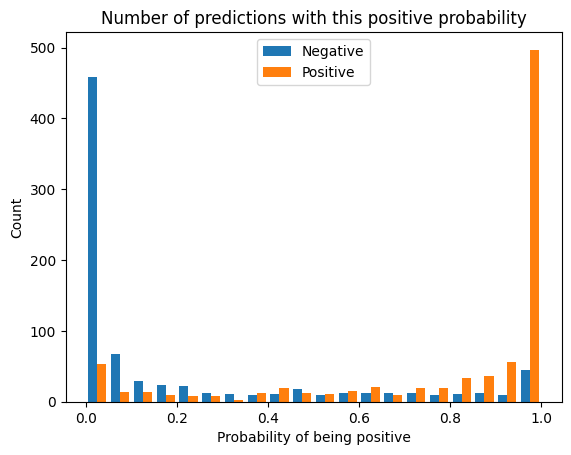

<Figure size 640x480 with 0 Axes>

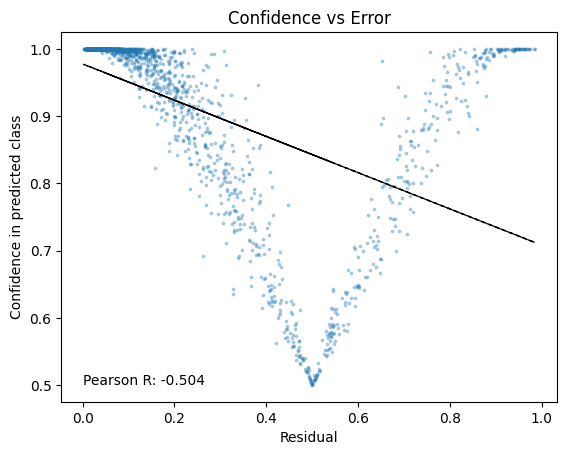

run with seed: 27
bal acc: 0.8059899930546697
mcc: 0.6193209301653739


<Figure size 640x480 with 0 Axes>

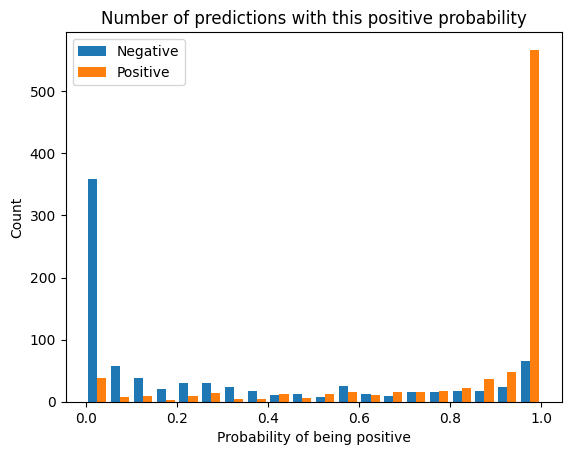

<Figure size 640x480 with 0 Axes>

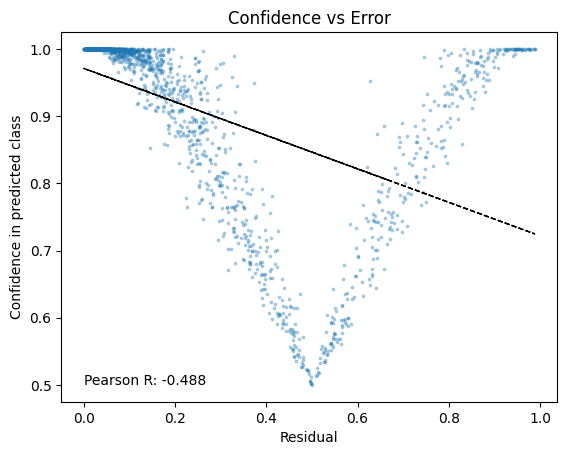

run with seed: 23
bal acc: 0.8144037646525208
mcc: 0.6330261481761404


<Figure size 640x480 with 0 Axes>

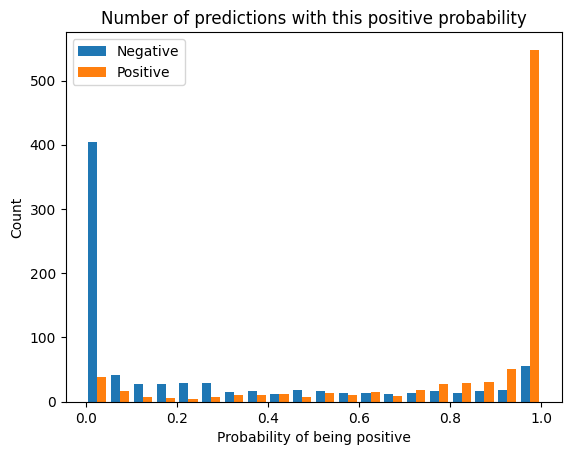

<Figure size 640x480 with 0 Axes>

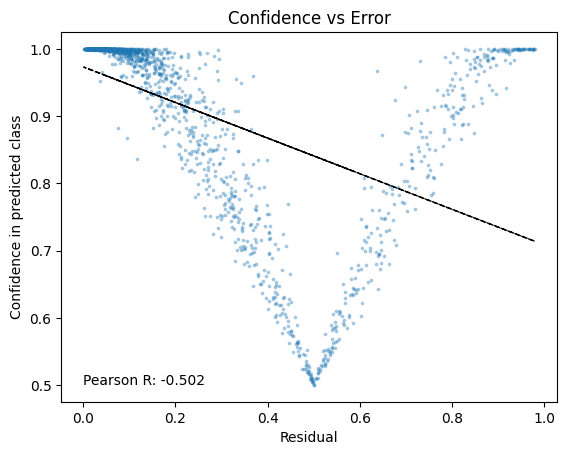

run with seed: 2
bal acc: 0.8197070204532891
mcc: 0.6392020687340347


<Figure size 640x480 with 0 Axes>

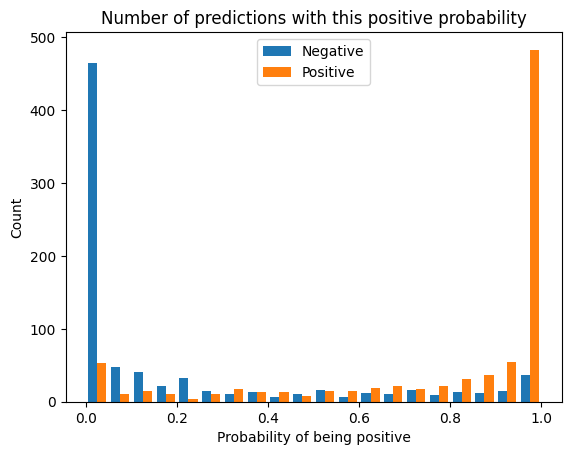

<Figure size 640x480 with 0 Axes>

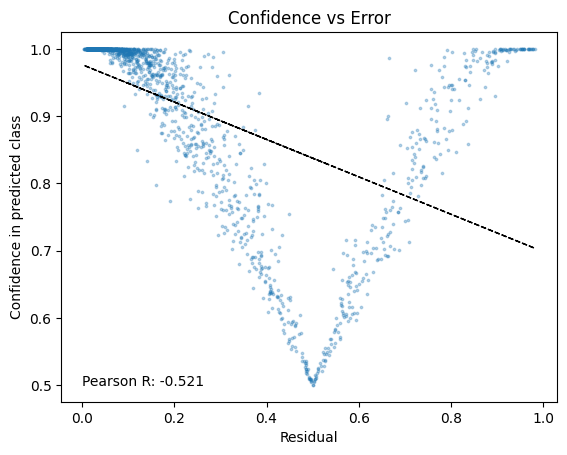

run with seed: 4
bal acc: 0.8148672591458661
mcc: 0.6305510426312588


<Figure size 640x480 with 0 Axes>

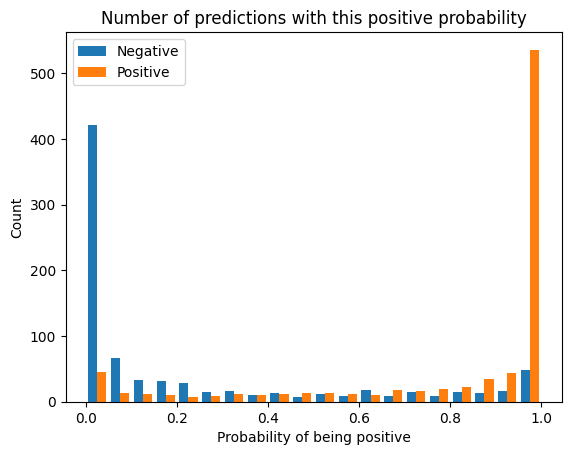

<Figure size 640x480 with 0 Axes>

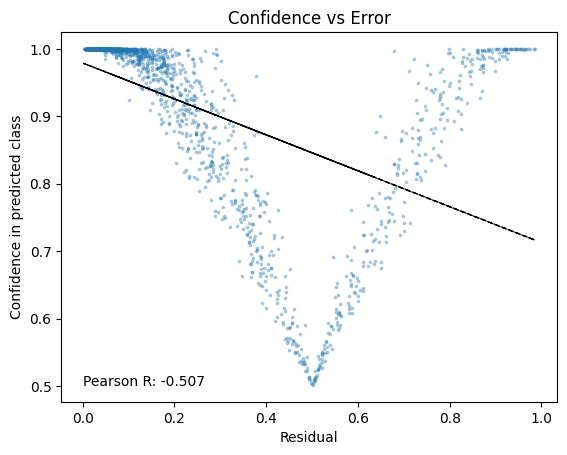

<Figure size 640x480 with 0 Axes>

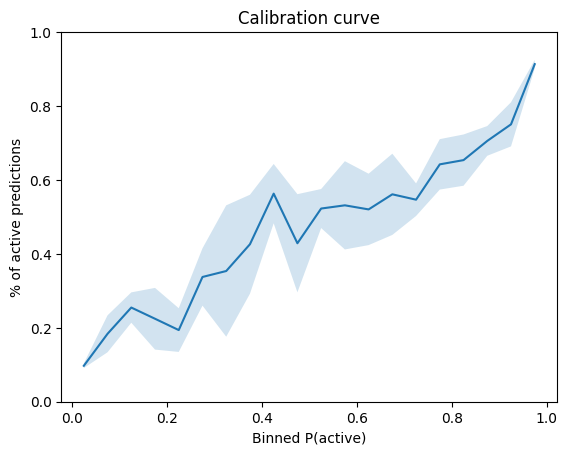

<Figure size 640x480 with 0 Axes>

In [58]:
# All data


smiles = all_data['SMILES']
y = all_data['Label'].values
featurizer = MorganFPFeaturizer(nBits=8000, radius=2)

X = featurizer.transform(smiles)

indices = np.arange(len(X))

# in this experiment, train_test_split should not be affected by the seed to avoid this becoming a bootstrap (it's only a replicate to ensure the model works in general)
X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(X, y, indices, test_size = 0.2, random_state = 0)

#seeds = [0]
seeds = [0, 27, 23, 2, 4]

cali = []
n_bins = 20
conflevel = np.arange(0.025, 1.025, 0.05)

for seed in seeds:
    set_seed(seed)

    X_train, y_train = shuffle(X_train, y_train, random_state = seed)

    model = BNNClassifier(
        bnn.BayesLinear(prior_mu = 0, prior_sigma = 0.03, in_features = 8000, out_features = 10),
        nn.ReLU(),
        bnn.BayesLinear(prior_mu = 0, prior_sigma = 0.03, in_features = 10, out_features = 10),
        nn.ReLU(),
        bnn.BayesLinear(prior_mu = 0, prior_sigma = 0.03, in_features = 10, out_features = 10),
        nn.ReLU(),
        bnn.BayesLinear(prior_mu = 0, prior_sigma = 0.03, in_features = 10, out_features = 2)
    )


    # convert format of X and y to Tensor objects
    X_in = torch.from_numpy(X_train).float() # need same dtype as weight matrix
    y_in = torch.from_numpy(y_train).long()

    model.set_hparams(kl_weight = 1, lr = 0.003)
    model.fit(X_in, y_in)

    model.sample_posterior(X_test, n_samples = 5000)
    y_mu, y_sigma = model.predict_normal_distribution(X_test, resample = False)

    y_pred = [int(x>0) for x in y_mu]
    print('run with seed:', seed)
    print('bal acc:', balanced_accuracy_score(y_test, y_pred))
    print('mcc:', matthews_corrcoef(y_test, y_pred))


    y_proba = np.array(model.predict_proba(X_test, resample = False))
    positives = y_proba[np.where(y_test==1)]
    negatives = y_proba[np.where(y_test==0)]
    f = plt.figure()
    ax = f.add_subplot(1,1,1)
    ax.hist([negatives, positives], n_bins)
    ax.set_title("Number of predictions with this positive probability")
    ax.set_xlabel("Probability of being positive")
    ax.set_ylabel("Count")
    ax.legend(['Negative', 'Positive'])
    #plt.savefig(f'/content/drive/MyDrive/Chemistry_PhD/interpretability/tests/uncertainty/all_data/{seed}_prob.png')
    plt.show()
    plt.clf()

    y_softmax = np.array(model.predict_softmax_proba(X_test, resample = False))
    confidence = np.array([max(x, 1-x) for x in y_proba])
    error = np.array([np.abs(y_test[x] - y_softmax[x]) for x in range(len(X_test))])
    gradient, intercept = np.polyfit(error, confidence, 1)
    f = plt.figure()
    ax = f.add_subplot(1,1,1)
    ax.scatter(error, confidence, s = 3, alpha = 0.3)
    ax.plot(error, error*gradient + intercept, color = 'k', ls = 'dashed', lw = 1)
    ax.set_title("Confidence vs Error")
    ax.set_xlabel("Residual")
    ax.set_ylabel("Confidence in predicted class")
    ax.text(0, 0.5, f'Pearson R: {np.around(st.pearsonr(error, confidence)[0],3)}')
    #plt.savefig(f'/content/drive/MyDrive/Chemistry_PhD/interpretability/tests/uncertainty/all_data/{seed}_confidence_vs_error.png')
    plt.show()
    plt.clf()


    poshist = np.histogram(positives, n_bins)[0]
    neghist = np.histogram(negatives, n_bins)[0]
    cali.append((poshist/(poshist+neghist)))


    '''
    for i in range(len(X)): # 8016, 8038, 8040, 8046, 8047, 8050, 8052, 8056, 8058, 8059, 8060, 8073, 8074, 8118, 8119, 8157, 8158, 8159, 8161, 8162 skipped because it contained only one atom
        probe = smiles[i]
        X_probe = X[i]
        y_probe = y[i]
        y_predict = model.predict(X_probe.reshape(1,-1))
        if i in id_train:
            istrain = 1
        else:
            istrain = 0

        probe_mol = Chem.MolFromSmiles(probe)
        if probe_mol.GetNumAtoms() < 2:
            print(f'Skipped mol: {i} because there was only 1 atom')

        else:
            explanation = model.rdkit_sim_map(probe, n_samples = 100, plot = True)
            plt.savefig(f'/content/drive/MyDrive/Chemistry_PhD/interpretability/tests/interpretability/all_data/{seed}/id{i}_istrain{istrain}_true{y_probe}_pred{y_predict}.png', bbox_inches='tight')
            plt.clf()

    '''

cali_means = np.mean(np.array(cali), axis = 0)
cali_stds = np.std(np.array(cali), axis = 0)
cali_minmax = [cali_means-cali_stds, cali_means+cali_stds]

f = plt.figure()
ax = f.add_subplot(1,1,1)
ax.plot(conflevel, cali_means)
ax.fill_between(conflevel, cali_minmax[0], cali_minmax[1], alpha = 0.2)
ax.set_title("Calibration curve")
ax.set_xlabel("Binned P(active)")
ax.set_ylabel("% of active predictions")
ax.set_ylim([0, 1])
plt.savefig(f'/content/drive/MyDrive/Chemistry_PhD/interpretability/tests/uncertainty/all_data/calibration_curve.png')
plt.show()
plt.clf()

In [ ]:
# test interpretations from Enoch and Cronin 2010 with RDKit SimilarityMap
# use model from previous block

dna_alerts = pd.read_csv('/content/drive/MyDrive/Chemistry_PhD/interpretability/tests/interpretability/DNA_binding_alerts.csv')
sa_hits = pd.read_csv('/content/drive/MyDrive/Chemistry_PhD/interpretability/tests/interpretability/SA_hit_summary.csv')

names = dna_alerts['Structural Alert'].values
smarts = dna_alerts['SMARTS'].values

assert(len(names) == len(smarts))
all_top_ns = []
test_top_ns = []

#for j in range(0, len(names)):
for j in [20, 52]:
    name = names[j]
    probe = smarts[j]

    alert = Chem.MolFromSmarts(probe)
    top_n_count = alert.GetNumAtoms()

    # change data path for model
    path = f'/content/drive/MyDrive/Chemistry_PhD/interpretability/tests/interpretability/all_data/similaritymap/{name}'
    if os.path.exists(path) == False:
        os.mkdir(path)

    train_cm = np.array([[0,0],[0,0]])
    test_cm = np.array([[0,0],[0,0]])

    top_n_num = np.array([0, 0]) # all, test
    top_n_denom = np.array([0, 0]) # all, test


    for i in range(len(X)):
        mol = Chem.MolFromSmiles(smiles[i])
        if mol.HasSubstructMatch(alert):
            X_probe = X[i]
            y_probe = y[i]
            y_predi = model.predict(X_probe.reshape(1,-1), n_samples = 250)[0]


            if i in id_train:
                istrain = 1
                train_cm[y_probe, y_predi] += 1
            else:
                istrain = 0
                test_cm[y_probe, y_predi] += 1


            # use this code to generate explanation plots
            explanation = model.rdkit_sim_map(smiles[i], n_samples = 50, plot = True)
            plt.savefig(path + f'/id{i}_istrain{istrain}_true{y_probe}_pred{y_predi}.png', bbox_inches='tight')
            plt.clf()

    np.savetxt(path+'/train_cm.txt', train_cm.astype(int), fmt = '%i', delimiter = ',')
    np.savetxt(path+'/test_cm.txt', test_cm.astype(int), fmt = '%i', delimiter = ',')

'''
            # compute top n score
            a_lbls = [int(x) for x in atom_labels[i][1:-1].split(', ')]
            raw_weights = np.squeeze(model.rdkit_sim_map(smiles[i], n_samples = 50, plot = False))
            a_weights, maxweight = SimilarityMaps.GetStandardizedWeights(raw_weights)
            assert len(a_lbls) == len(a_weights)
            top_n_lbls = np.nonzero(a_lbls)[0]
            top_n_denom[0] += top_n_count
            if not istrain:
                top_n_denom[1] += top_n_count
            top_n_found = np.argpartition(a_weights, -top_n_count)[-top_n_count:]


            for idx in top_n_found:
                if idx in top_n_lbls:
                    top_n_num[0] += 1
                    if not istrain:
                        top_n_num[1] += 1

    top_n_score = np.divide(top_n_num, top_n_denom)
    all_top_ns.append(top_n_score[0])
    test_top_ns.append(top_n_score[1])
    top_ns = np.concatenate((top_n_num, top_n_denom, top_n_score), axis = 0)
    np.savetxt(path+'/top_n_score.txt', top_ns, fmt = '%1.3f', delimiter = ',')

sa_hits['All_top-n'] = all_top_ns
sa_hits['Test_top-n'] = test_top_ns
sa_hits.to_csv('/content/drive/MyDrive/Chemistry_PhD/interpretability/tests/interpretability/all_data/similaritymap/SA_hits.csv', index = False)
'''




[17:11:32] WARNING: not removing hydrogen atom without neighbors
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
[17:12:52] WARNING: not removing hydrogen atom without neighbors
[17:12:52] WARNING: not removing hydrogen atom without neighbors
[17:12:52] WARNING: not removing hydrogen atom without neighbors
[17:13:30] WARNING: not removing hydrogen atom without neighbors
[17:13:30] WARNING: not removing hydrogen atom without neighbors
[17:13:30] WARNING: not removing hydrogen atom without neighbors
[17:13:30] WARNING: not removing hydrogen atom without neighbors
[17:13:30] WARNING: not removing hydrogen atom without neighbors
[17:16:56] WARNING: not removing hydrogen atom without neighbors
[17:17:38] WARNING: not removing hydrogen atom withou

"\n            # compute top n score\n            a_lbls = [int(x) for x in atom_labels[i][1:-1].split(', ')]\n            raw_weights = np.squeeze(model.rdkit_sim_map(smiles[i], n_samples = 50, plot = False))\n            a_weights, maxweight = SimilarityMaps.GetStandardizedWeights(raw_weights)\n            assert len(a_lbls) == len(a_weights)\n            top_n_lbls = np.nonzero(a_lbls)[0]\n            top_n_denom[0] += top_n_count\n            if not istrain: \n                top_n_denom[1] += top_n_count\n            top_n_found = np.argpartition(a_weights, -top_n_count)[-top_n_count:]\n            \n            \n            for idx in top_n_found: \n                if idx in top_n_lbls: \n                    top_n_num[0] += 1\n                    if not istrain: \n                        top_n_num[1] += 1\n    \n    top_n_score = np.divide(top_n_num, top_n_denom)\n    all_top_ns.append(top_n_score[0])\n    test_top_ns.append(top_n_score[1])\n    top_ns = np.concatenate((top_n_nu

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

In [ ]:
# test interpretations from Enoch and Cronin 2010 with SHAP + BNN
# use model from previous block

dna_alerts = pd.read_csv('/content/drive/MyDrive/Chemistry_PhD/interpretability/tests/interpretability/DNA_binding_alerts.csv')

names = dna_alerts['Structural Alert'].values
smarts = dna_alerts['SMARTS'].values
model.config_explainer(DeepExplainer, torch.from_numpy(shap.sample(X_test, 100)).float())

class BlockPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

assert(len(names) == len(smarts))


#for j in range(0, len(names)):
for j in [20, 52]:
    name = names[j]
    probe = smarts[j]

    alert = Chem.MolFromSmarts(probe)

    # change data path for model
    path = f'/content/drive/MyDrive/Chemistry_PhD/interpretability/tests/interpretability/all_data/deepexplainer/{name}'
    if os.path.exists(path) == False:
        os.mkdir(path)

    train_cm = np.array([[0,0],[0,0]])
    test_cm = np.array([[0,0],[0,0]])


    for i in range(len(X)):
        mol = Chem.MolFromSmiles(smiles[i])
        if mol.HasSubstructMatch(alert):
            X_probe = X[i]
            y_probe = y[i]
            y_predi = model.predict(X_probe.reshape(1,-1), n_samples = 250)[0]

            if i in id_train:
                istrain = 1
                train_cm[y_probe, y_predi] += 1
            else:
                istrain = 0
                test_cm[y_probe, y_predi] += 1

            with BlockPrints():
                explanation = model.explain(smiles[i], n_samples = 50, plot = True)
            plt.savefig(path + f'/id{i}_istrain{istrain}_true{y_probe}_pred{y_predi}.png', bbox_inches='tight')
            plt.clf()

    np.savetxt(path+'/train_cm.txt', train_cm.astype(int), fmt = '%i', delimiter = ',')
    np.savetxt(path+'/test_cm.txt', test_cm.astype(int), fmt = '%i', delimiter = ',')



Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
[17:49:12] WARNING: not removing hydrogen atom without neighbors
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
[17:50:14] WARNING: not removing hydrogen atom without neighbors
[17:50:14] WARNING: not removing hydrogen atom without neighbors
[17:50:14] WARNING: not removing hydrogen atom without neighbors
[17:50:45] WARNING: not removing hydrogen atom without neighbors
[17:50:45] WARNING: not removing hydrogen atom without neighbors
[17:50:45] WARNING: not removing hydrogen atom without neighbors

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

[14:42:58] WARNING: not removing hydrogen atom without neighbors
[14:42:58] WARNING: not removing hydrogen atom without neighbors
[14:42:58] WARNING: not removing hydrogen atom without neighbors
[14:42:58] WARNING: not removing hydrogen atom without neighbors
[14:42:58] WARNING: not removing hydrogen atom without neighbors
[14:42:59] WARNING: not removing hydrogen atom without neighbors
[14:42:59] WARNING: not removing hydrogen atom without neighbors
[14:42:59] WARNING: not removing hydrogen atom without neighbors
[14:42:59] WARNING: not removing hydrogen atom without neighbors
[14:42:59] WARNING: not removing hydrogen atom without neighbors
[14:42:59] WARNING: not removing hydrogen atom without neighbors
[14:42:59] WARNING: not removing hydrogen atom without neighbors
[14:42:59] WARNING: not removing hydrogen atom without neighbors
[14:42:59] WARNING: not removing hydrogen atom without neighbors
[14:42:59] WARNING: not removing hydrogen atom without neighbors
[14:42:59] WARNING: not r

run with seed: 0
0.7229280027492984
0.4444102783195737


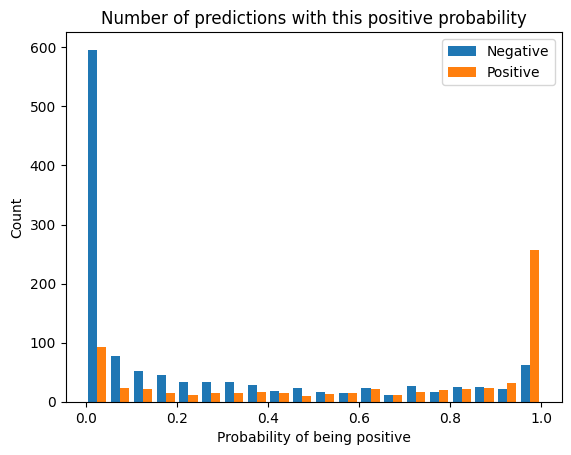

<Figure size 640x480 with 0 Axes>

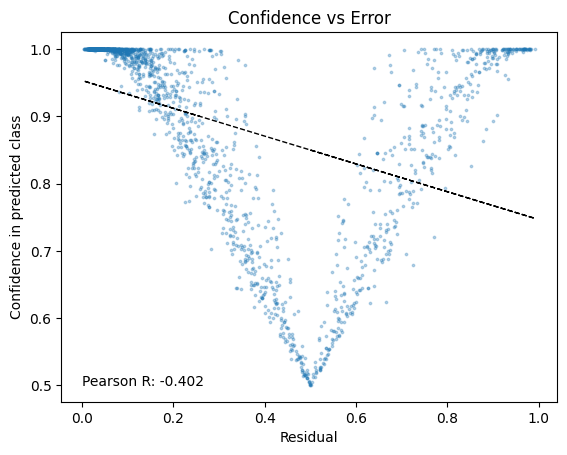

run with seed: 27
0.7188708784390094
0.4294885440356602


<Figure size 640x480 with 0 Axes>

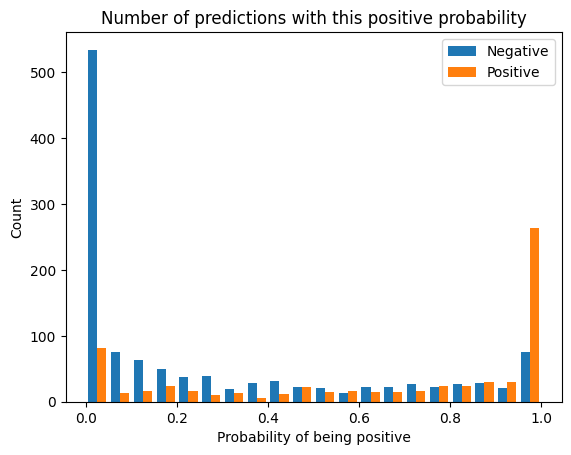

<Figure size 640x480 with 0 Axes>

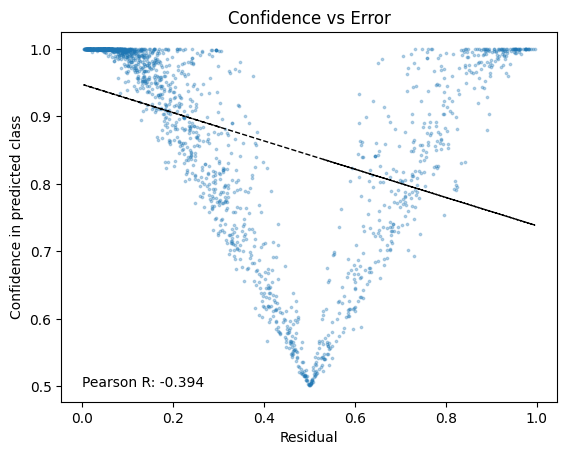

run with seed: 23
0.7201271550489718
0.43681379168543066


<Figure size 640x480 with 0 Axes>

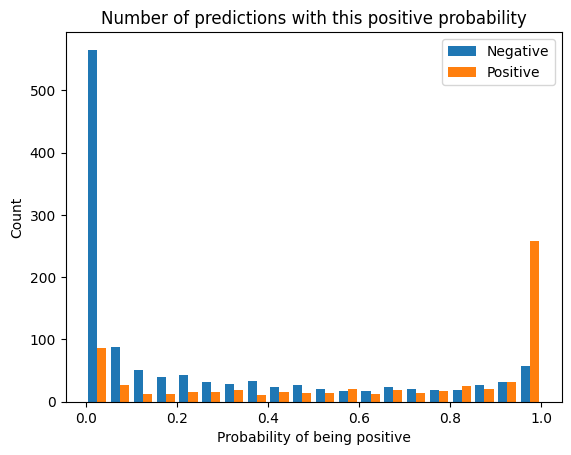

<Figure size 640x480 with 0 Axes>

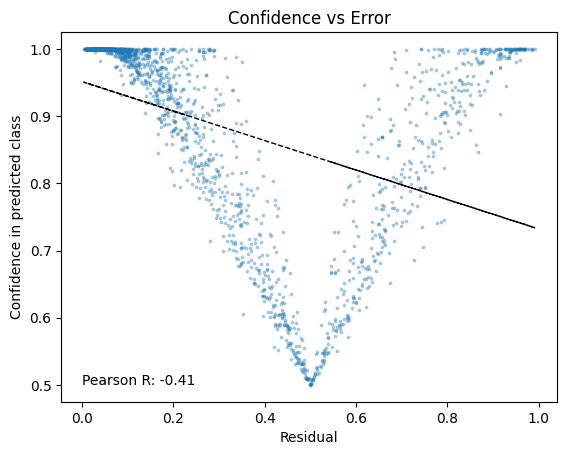

run with seed: 2
0.7207896595834049
0.4606318470774807


<Figure size 640x480 with 0 Axes>

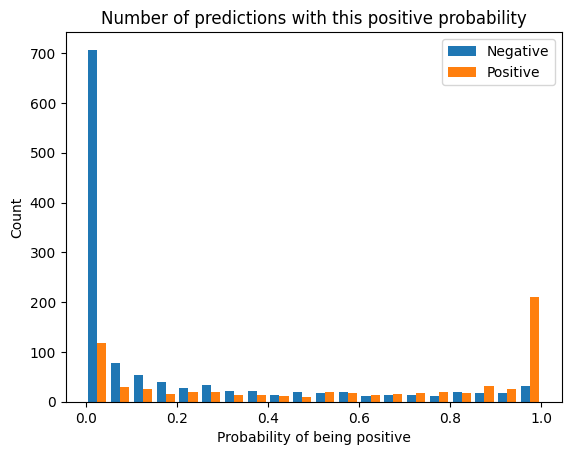

<Figure size 640x480 with 0 Axes>

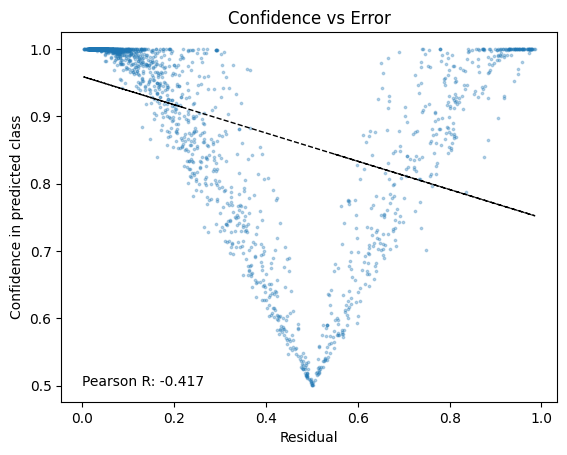

run with seed: 4
0.7209614907306643
0.44436401511311724


<Figure size 640x480 with 0 Axes>

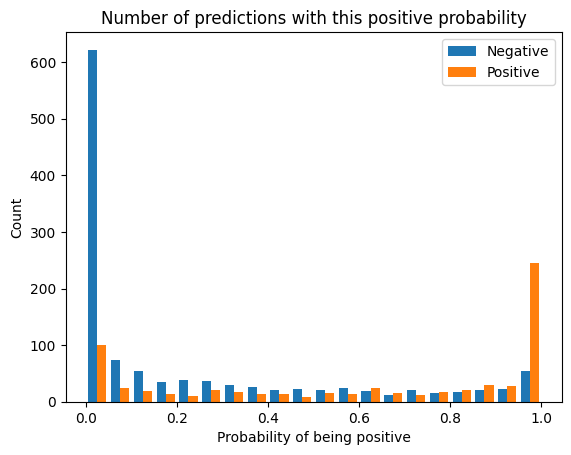

<Figure size 640x480 with 0 Axes>

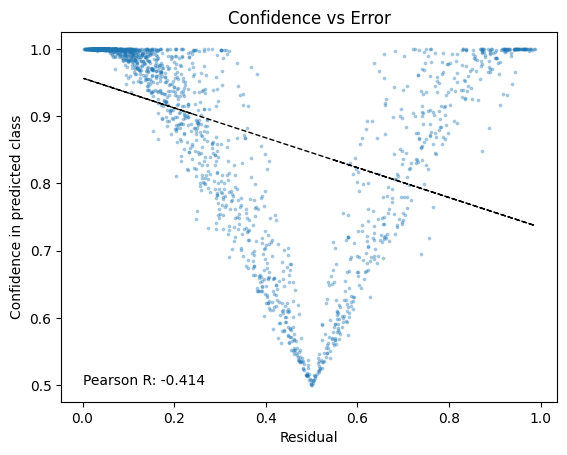

<Figure size 640x480 with 0 Axes>

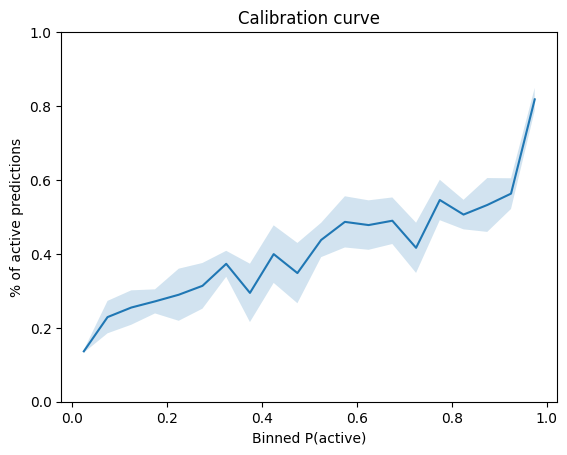

<Figure size 640x480 with 0 Axes>

In [55]:
# Xu dataset

smiles_train = xu_train['SMILES']
smiles_test = xu_test['SMILES']
featurizer = MorganFPFeaturizer(nBits=8000, radius=2)


X_train = featurizer.transform(smiles_train)
y_train = xu_train['Label'].values
X_test = featurizer.transform(smiles_test)
y_test = xu_test['Label'].values

#seeds = [0]
seeds = [0, 27, 23, 2, 4]

cali = []
n_bins = 20
conflevel = np.arange(0.025, 1.025, 0.05)

for seed in seeds:
    set_seed(seed)

    X_train, y_train = shuffle(X_train, y_train, random_state = seed)

    model = BNNClassifier(
        bnn.BayesLinear(prior_mu = 0, prior_sigma = 0.03, in_features = 8000, out_features = 10),
        nn.ReLU(),
        bnn.BayesLinear(prior_mu = 0, prior_sigma = 0.03, in_features = 10, out_features = 10),
        nn.ReLU(),
        bnn.BayesLinear(prior_mu = 0, prior_sigma = 0.03, in_features = 10, out_features = 10),
        nn.ReLU(),
        bnn.BayesLinear(prior_mu = 0, prior_sigma = 0.03, in_features = 10, out_features = 2)
    )


    # convert format of X and y to Tensor objects
    X_in = torch.from_numpy(X_train).float() # need same dtype as weight matrix
    y_in = torch.from_numpy(y_train).long()

    model.set_hparams(kl_weight = 1, lr = 0.003)
    model.fit(X_in, y_in)

    model.sample_posterior(X_test, n_samples = 5000)
    y_mu, y_sigma = model.predict_normal_distribution(X_test, resample = False, n_samples = 5000)

    y_pred = [int(x>0) for x in y_mu]
    print('run with seed:', seed)
    print(balanced_accuracy_score(y_test, y_pred))
    print(matthews_corrcoef(y_test, y_pred))

    y_proba = np.array(model.predict_proba(X_test, resample = False))
    positives = y_proba[np.where(y_test==1)]
    negatives = y_proba[np.where(y_test==0)]
    f = plt.figure()
    ax = f.add_subplot(1,1,1)
    ax.hist([negatives, positives], n_bins)
    ax.set_title("Number of predictions with this positive probability")
    ax.set_xlabel("Probability of being positive")
    ax.set_ylabel("Count")
    ax.legend(['Negative', 'Positive'])
    #plt.savefig(f'/content/drive/MyDrive/Chemistry_PhD/interpretability/tests/uncertainty/xu_data/{seed}_prob.png')
    plt.show()
    plt.clf()


    y_softmax = np.array(model.predict_softmax_proba(X_test, resample = False))
    confidence = np.array([max(x, 1-x) for x in y_proba])
    error = np.array([np.abs(y_test[x] - y_softmax[x]) for x in range(len(X_test))])
    gradient, intercept = np.polyfit(error, confidence, 1)
    f = plt.figure()
    ax = f.add_subplot(1,1,1)
    ax.scatter(error, confidence, s = 3, alpha = 0.3)
    ax.plot(error, error*gradient + intercept, color = 'k', ls = 'dashed', lw = 1)
    ax.set_title("Confidence vs Error")
    ax.set_xlabel("Residual")
    ax.set_ylabel("Confidence in predicted class")
    ax.text(0, 0.5, f'Pearson R: {np.around(st.pearsonr(error, confidence)[0],3)}')
    #plt.savefig(f'/content/drive/MyDrive/Chemistry_PhD/interpretability/tests/uncertainty/xu_data/{seed}_confidence_vs_error.png')
    plt.show()
    plt.clf()

    poshist = np.histogram(positives, n_bins)[0]
    neghist = np.histogram(negatives, n_bins)[0]
    cali.append((poshist/(poshist+neghist)))

cali_means = np.mean(np.array(cali), axis = 0)
cali_stds = np.std(np.array(cali), axis = 0)
cali_minmax = [cali_means-cali_stds, cali_means+cali_stds]

f = plt.figure()
ax = f.add_subplot(1,1,1)
ax.plot(conflevel, cali_means)
ax.fill_between(conflevel, cali_minmax[0], cali_minmax[1], alpha = 0.2)
ax.set_title("Calibration curve")
ax.set_xlabel("Binned P(active)")
ax.set_ylabel("% of active predictions")
ax.set_ylim([0, 1])
plt.savefig(f'/content/drive/MyDrive/Chemistry_PhD/interpretability/tests/uncertainty/xu_data/calibration_curve.png')
plt.show()
plt.clf()

[14:57:22] WARNING: not removing hydrogen atom without neighbors
[14:57:22] WARNING: not removing hydrogen atom without neighbors
[14:57:22] WARNING: not removing hydrogen atom without neighbors
[14:57:22] WARNING: not removing hydrogen atom without neighbors
[14:57:23] WARNING: not removing hydrogen atom without neighbors
[14:57:23] WARNING: not removing hydrogen atom without neighbors
[14:57:23] WARNING: not removing hydrogen atom without neighbors
[14:57:23] WARNING: not removing hydrogen atom without neighbors
[14:57:23] WARNING: not removing hydrogen atom without neighbors
[14:57:23] WARNING: not removing hydrogen atom without neighbors
[14:57:23] WARNING: not removing hydrogen atom without neighbors
[14:57:23] WARNING: not removing hydrogen atom without neighbors
[14:57:23] WARNING: not removing hydrogen atom without neighbors
[14:57:24] WARNING: not removing hydrogen atom without neighbors
[14:57:24] WARNING: not removing hydrogen atom without neighbors
[14:57:24] WARNING: not r

run with seed: 0
0.7113192002706956
0.40856171090832705


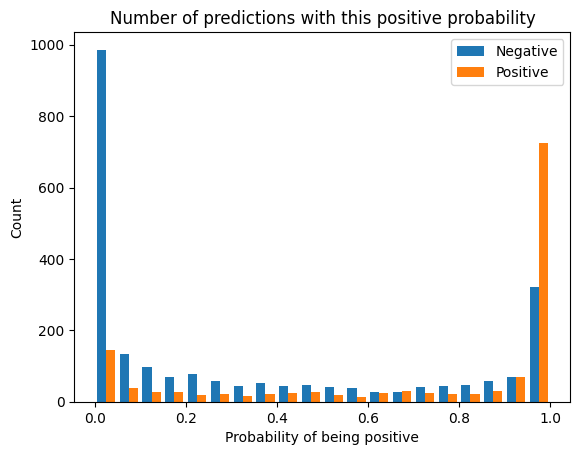

<Figure size 640x480 with 0 Axes>

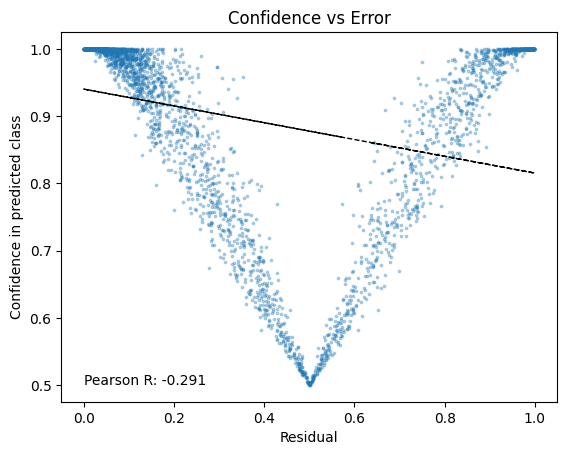

run with seed: 27
0.7089897907033419
0.4037601117160503


<Figure size 640x480 with 0 Axes>

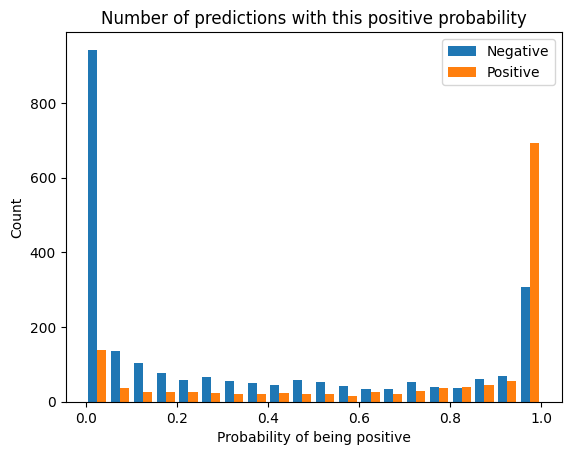

<Figure size 640x480 with 0 Axes>

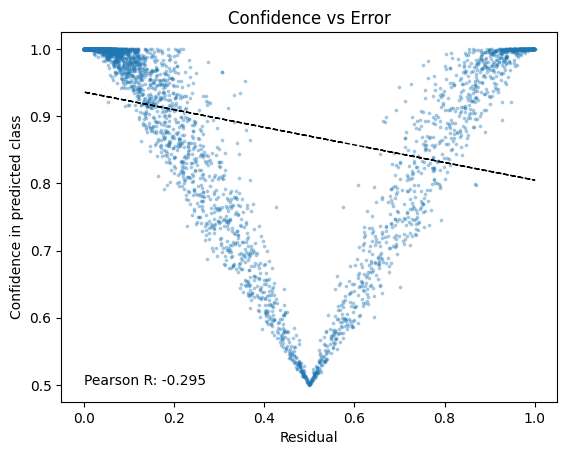

run with seed: 23
0.7114023534920195
0.40959328759783903


<Figure size 640x480 with 0 Axes>

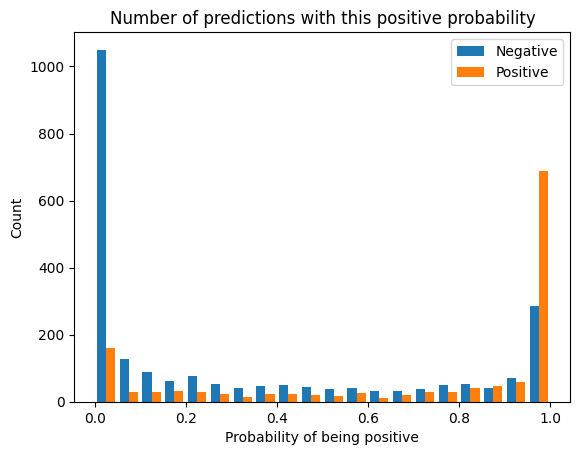

<Figure size 640x480 with 0 Axes>

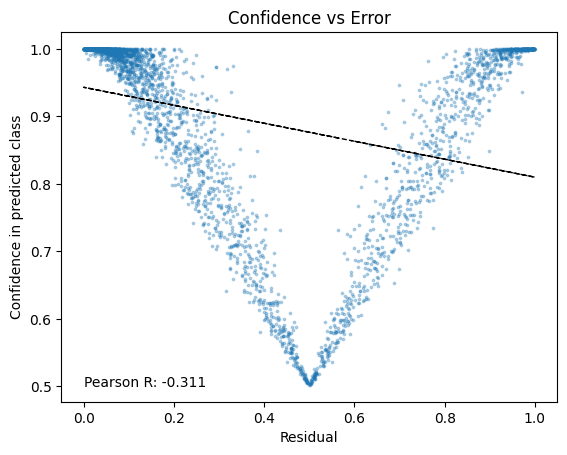

run with seed: 2
0.7144358469699286
0.4224274979293345


<Figure size 640x480 with 0 Axes>

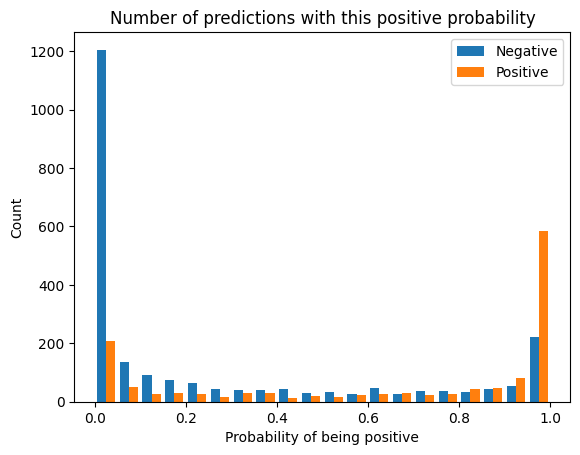

<Figure size 640x480 with 0 Axes>

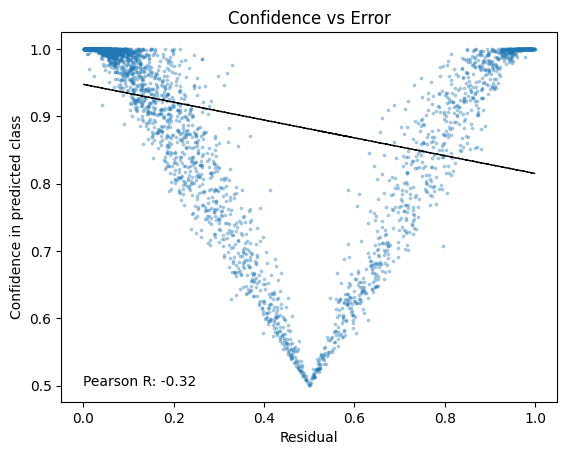

run with seed: 4
0.7146758719414806
0.417762783136773


<Figure size 640x480 with 0 Axes>

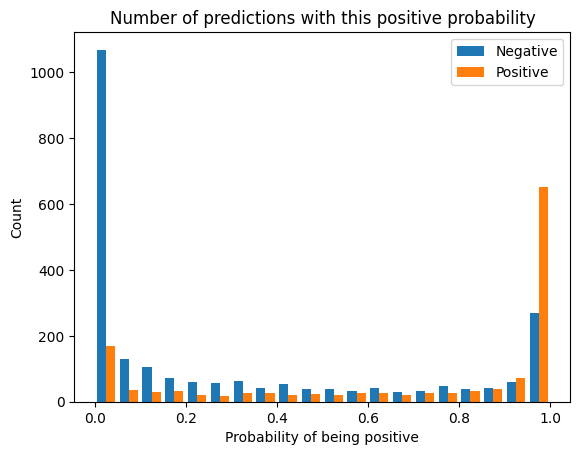

<Figure size 640x480 with 0 Axes>

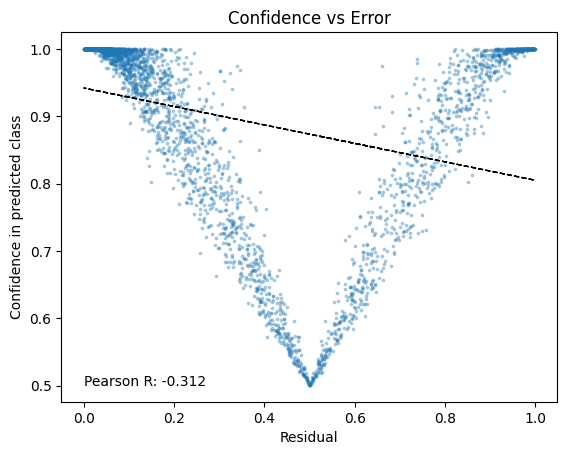

<Figure size 640x480 with 0 Axes>

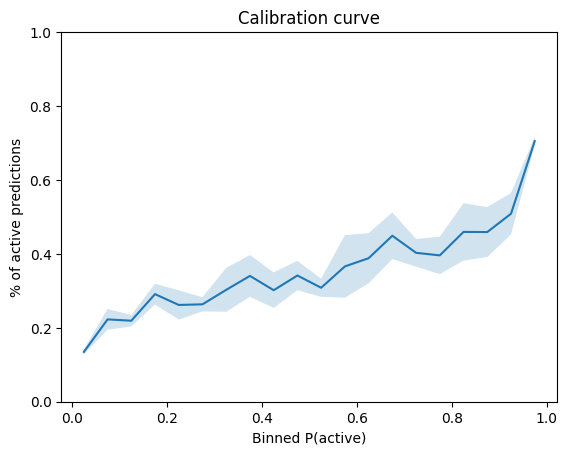

<Figure size 640x480 with 0 Axes>

In [56]:
# Martinez dataset


smiles_train = martinez_train['SMILES']
smiles_test = martinez_test['SMILES']
featurizer = MorganFPFeaturizer(nBits=8000, radius=2)


X_train = featurizer.transform(smiles_train)
y_train = martinez_train['Label'].values
X_test = featurizer.transform(smiles_test)
y_test = martinez_test['Label'].values

#seeds = [0]
seeds = [0, 27, 23, 2, 4]

cali = []
n_bins = 20
conflevel = np.arange(0.025, 1.025, 0.05)


for seed in seeds:
    set_seed(seed)

    X_train, y_train = shuffle(X_train, y_train, random_state = seed)

    model = BNNClassifier(
        bnn.BayesLinear(prior_mu = 0, prior_sigma = 0.03, in_features = 8000, out_features = 10),
        nn.ReLU(),
        bnn.BayesLinear(prior_mu = 0, prior_sigma = 0.03, in_features = 10, out_features = 10),
        nn.ReLU(),
        bnn.BayesLinear(prior_mu = 0, prior_sigma = 0.03, in_features = 10, out_features = 10),
        nn.ReLU(),
        bnn.BayesLinear(prior_mu = 0, prior_sigma = 0.03, in_features = 10, out_features = 2)
    )


    # convert format of X and y to Tensor objects
    X_in = torch.from_numpy(X_train).float() # need same dtype as weight matrix
    y_in = torch.from_numpy(y_train).long()

    model.set_hparams(kl_weight = 1, lr = 0.003)
    model.fit(X_in, y_in)

    model.sample_posterior(X_test, n_samples = 5000)
    y_mu, y_sigma = model.predict_normal_distribution(X_test, resample = False, n_samples = 5000)

    y_pred = [int(x>0) for x in y_mu]
    print('run with seed:', seed)
    print(balanced_accuracy_score(y_test, y_pred))
    print(matthews_corrcoef(y_test, y_pred))

    n_bins = 20
    y_proba = np.array(model.predict_proba(X_test, resample = False))
    positives = y_proba[np.where(y_test==1)]
    negatives = y_proba[np.where(y_test==0)]
    f = plt.figure()
    ax = f.add_subplot(1,1,1)
    ax.hist([negatives, positives], n_bins)
    ax.set_title("Number of predictions with this positive probability")
    ax.set_xlabel("Probability of being positive")
    ax.set_ylabel("Count")
    ax.legend(['Negative', 'Positive'])
    #plt.savefig(f'/content/drive/MyDrive/Chemistry_PhD/interpretability/tests/uncertainty/martinez_data/{seed}_prob.png')
    plt.show()
    plt.clf()


    y_softmax = np.array(model.predict_softmax_proba(X_test, resample = False))
    confidence = np.array([max(x, 1-x) for x in y_proba])
    error = np.array([np.abs(y_test[x] - y_softmax[x]) for x in range(len(X_test))])
    gradient, intercept = np.polyfit(error, confidence, 1)
    f = plt.figure()
    ax = f.add_subplot(1,1,1)
    ax.scatter(error, confidence, s = 3, alpha = 0.3)
    ax.plot(error, error*gradient + intercept, color = 'k', ls = 'dashed', lw = 1)
    ax.set_title("Confidence vs Error")
    ax.set_xlabel("Residual")
    ax.set_ylabel("Confidence in predicted class")
    ax.text(0, 0.5, f'Pearson R: {np.around(st.pearsonr(error, confidence)[0],3)}')
    #plt.savefig(f'/content/drive/MyDrive/Chemistry_PhD/interpretability/tests/uncertainty/martinez_data/{seed}_confidence_vs_error.png')
    plt.show()
    plt.clf()

    poshist = np.histogram(positives, n_bins)[0]
    neghist = np.histogram(negatives, n_bins)[0]
    cali.append((poshist/(poshist+neghist)))

cali_means = np.mean(np.array(cali), axis = 0)
cali_stds = np.std(np.array(cali), axis = 0)
cali_minmax = [cali_means-cali_stds, cali_means+cali_stds]

f = plt.figure()
ax = f.add_subplot(1,1,1)
ax.plot(conflevel, cali_means)
ax.fill_between(conflevel, cali_minmax[0], cali_minmax[1], alpha = 0.2)
ax.set_title("Calibration curve")
ax.set_xlabel("Binned P(active)")
ax.set_ylabel("% of active predictions")
ax.set_ylim([0, 1])
plt.savefig(f'/content/drive/MyDrive/Chemistry_PhD/interpretability/tests/uncertainty/martinez_data/calibration_curve.png')
plt.show()
plt.clf()

[15:21:04] WARNING: not removing hydrogen atom without neighbors
[15:21:04] WARNING: not removing hydrogen atom without neighbors
[15:21:04] WARNING: not removing hydrogen atom without neighbors
[15:21:04] WARNING: not removing hydrogen atom without neighbors
[15:21:04] WARNING: not removing hydrogen atom without neighbors
[15:21:04] WARNING: not removing hydrogen atom without neighbors
[15:21:04] WARNING: not removing hydrogen atom without neighbors
[15:21:04] WARNING: not removing hydrogen atom without neighbors
[15:21:04] WARNING: not removing hydrogen atom without neighbors
[15:21:05] WARNING: not removing hydrogen atom without neighbors
[15:21:05] WARNING: not removing hydrogen atom without neighbors
[15:21:05] WARNING: not removing hydrogen atom without neighbors
[15:21:05] WARNING: not removing hydrogen atom without neighbors
[15:21:05] WARNING: not removing hydrogen atom without neighbors
[15:21:05] WARNING: not removing hydrogen atom without neighbors
[15:21:05] WARNING: not r

run with seed: 0
0.7316715121495998
0.45994328247491134


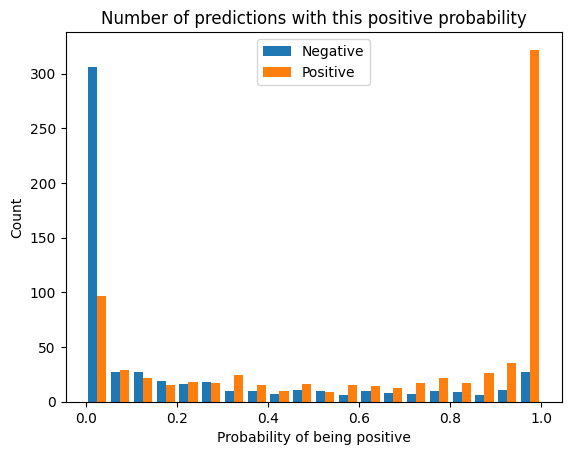

<Figure size 640x480 with 0 Axes>

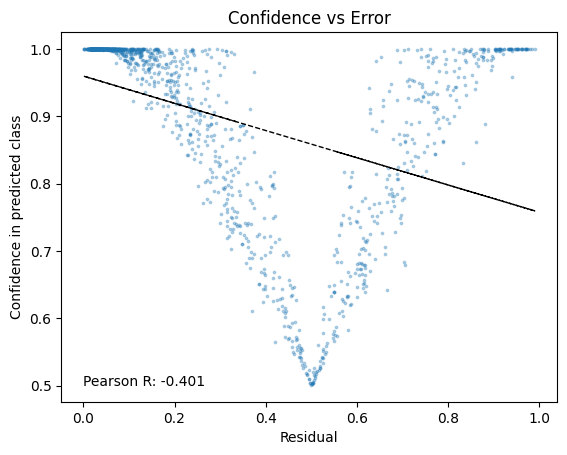

run with seed: 27
0.747195003768709
0.4937100097841502


<Figure size 640x480 with 0 Axes>

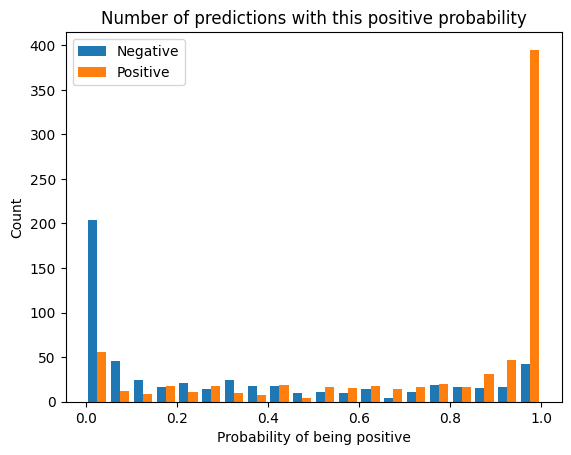

<Figure size 640x480 with 0 Axes>

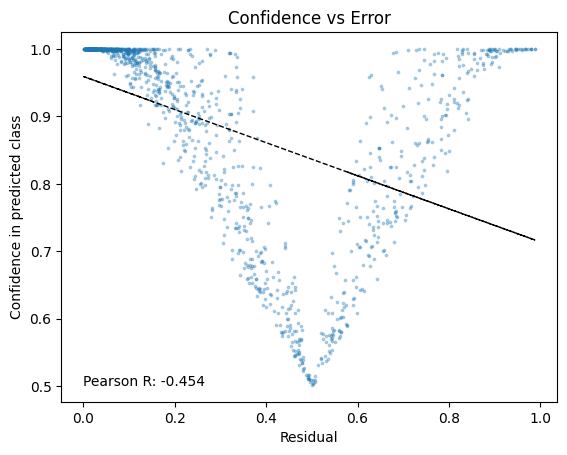

run with seed: 23
0.7521194501274182
0.49879273206044955


<Figure size 640x480 with 0 Axes>

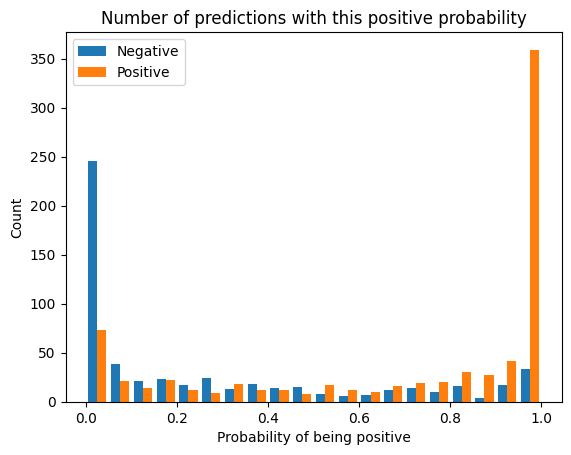

<Figure size 640x480 with 0 Axes>

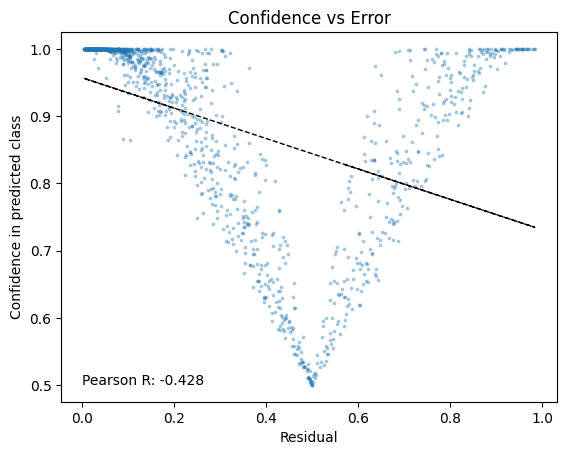

run with seed: 2
0.7464699759520477
0.48788091474313877


<Figure size 640x480 with 0 Axes>

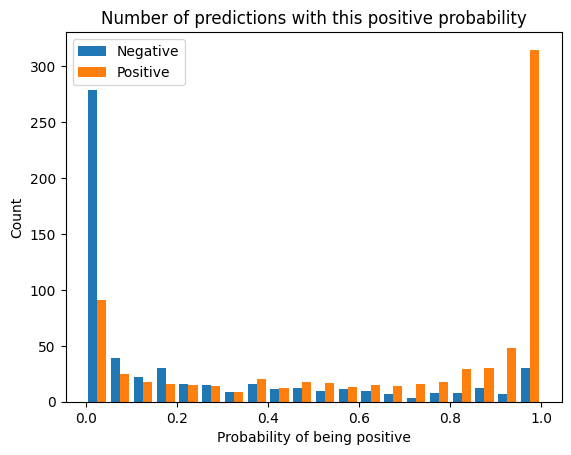

<Figure size 640x480 with 0 Axes>

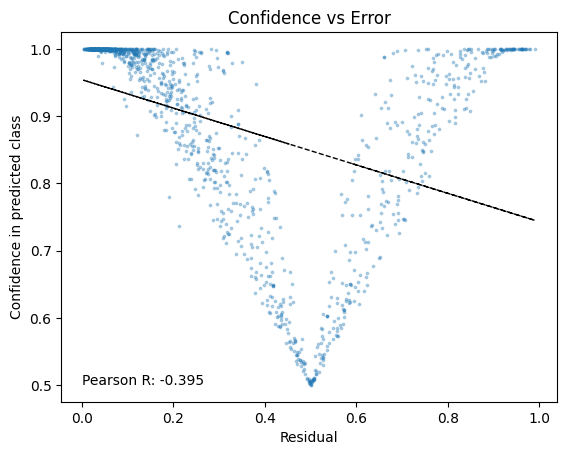

run with seed: 4
0.7431068518717922
0.48061293740928024


<Figure size 640x480 with 0 Axes>

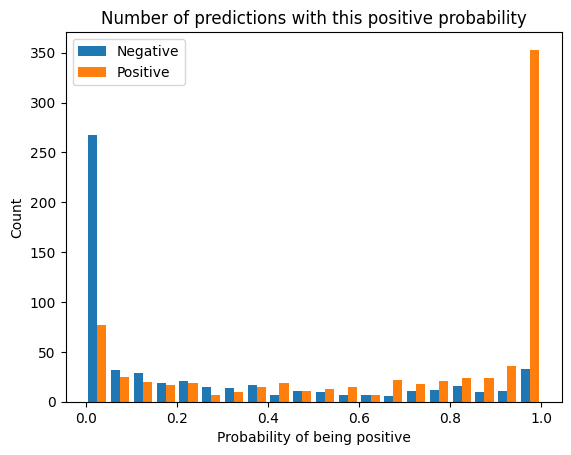

<Figure size 640x480 with 0 Axes>

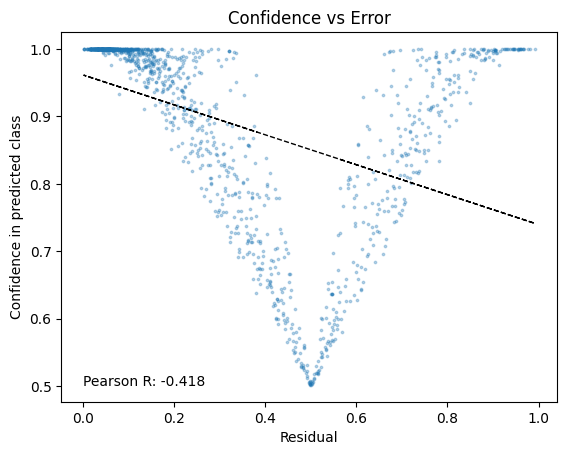

<Figure size 640x480 with 0 Axes>

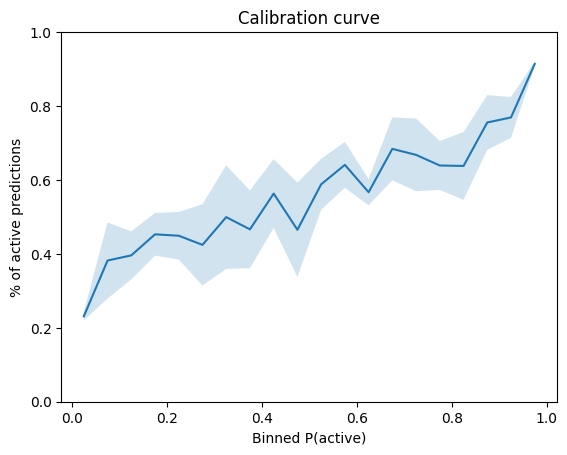

<Figure size 640x480 with 0 Axes>

In [57]:
# Helma dataset


smiles_train = helma_train['SMILES']
smiles_test = helma_test['SMILES']
featurizer = MorganFPFeaturizer(nBits=8000, radius=2)


X_train = featurizer.transform(smiles_train)
y_train = helma_train['Label'].values
X_test = featurizer.transform(smiles_test)
y_test = helma_test['Label'].values

#seeds = [0]
seeds = [0, 27, 23, 2, 4]

cali = []
n_bins = 20
conflevel = np.arange(0.025, 1.025, 0.05)

for seed in seeds:
    set_seed(seed)

    X_train, y_train = shuffle(X_train, y_train, random_state = seed)

    model = BNNClassifier(
        bnn.BayesLinear(prior_mu = 0, prior_sigma = 0.03, in_features = 8000, out_features = 10),
        nn.ReLU(),
        bnn.BayesLinear(prior_mu = 0, prior_sigma = 0.03, in_features = 10, out_features = 10),
        nn.ReLU(),
        bnn.BayesLinear(prior_mu = 0, prior_sigma = 0.03, in_features = 10, out_features = 10),
        nn.ReLU(),
        bnn.BayesLinear(prior_mu = 0, prior_sigma = 0.03, in_features = 10, out_features = 2)
    )


    # convert format of X and y to Tensor objects
    X_in = torch.from_numpy(X_train).float() # need same dtype as weight matrix
    y_in = torch.from_numpy(y_train).long()

    model.set_hparams(kl_weight = 1, lr = 0.003)
    model.fit(X_in, y_in)

    model.sample_posterior(X_test, n_samples = 5000)
    y_mu, y_sigma = model.predict_normal_distribution(X_test, resample = False, n_samples = 5000)

    y_pred = [int(x>0) for x in y_mu]
    print('run with seed:', seed)
    print(balanced_accuracy_score(y_test, y_pred))
    print(matthews_corrcoef(y_test, y_pred))

    n_bins = 20
    y_proba = np.array(model.predict_proba(X_test, resample = False))
    positives = y_proba[np.where(y_test==1)]
    negatives = y_proba[np.where(y_test==0)]
    f = plt.figure()
    ax = f.add_subplot(1,1,1)
    ax.hist([negatives, positives], n_bins)
    ax.set_title("Number of predictions with this positive probability")
    ax.set_xlabel("Probability of being positive")
    ax.set_ylabel("Count")
    ax.legend(['Negative', 'Positive'])
    #plt.savefig(f'/content/drive/MyDrive/Chemistry_PhD/interpretability/tests/uncertainty/helma_data/{seed}_prob.png')
    plt.show()
    plt.clf()


    y_softmax = np.array(model.predict_softmax_proba(X_test, resample = False))
    confidence = np.array([max(x, 1-x) for x in y_proba])
    error = np.array([np.abs(y_test[x] - y_softmax[x]) for x in range(len(X_test))])
    gradient, intercept = np.polyfit(error, confidence, 1)
    f = plt.figure()
    ax = f.add_subplot(1,1,1)
    ax.scatter(error, confidence, s = 3, alpha = 0.3)
    ax.plot(error, error*gradient + intercept, color = 'k', ls = 'dashed', lw = 1)
    ax.set_title("Confidence vs Error")
    ax.set_xlabel("Residual")
    ax.set_ylabel("Confidence in predicted class")
    ax.text(0, 0.5, f'Pearson R: {np.around(st.pearsonr(error, confidence)[0],3)}')
    #plt.savefig(f'/content/drive/MyDrive/Chemistry_PhD/interpretability/tests/uncertainty/helma_data/{seed}_confidence_vs_error.png')
    plt.show()
    plt.clf()

    poshist = np.histogram(positives, n_bins)[0]
    neghist = np.histogram(negatives, n_bins)[0]
    cali.append((poshist/(poshist+neghist)))

cali_means = np.mean(np.array(cali), axis = 0)
cali_stds = np.std(np.array(cali), axis = 0)
cali_minmax = [cali_means-cali_stds, cali_means+cali_stds]

f = plt.figure()
ax = f.add_subplot(1,1,1)
ax.plot(conflevel, cali_means)
ax.fill_between(conflevel, cali_minmax[0], cali_minmax[1], alpha = 0.2)
ax.set_title("Calibration curve")
ax.set_xlabel("Binned P(active)")
ax.set_ylabel("% of active predictions")
ax.set_ylim([0, 1])
plt.savefig(f'/content/drive/MyDrive/Chemistry_PhD/interpretability/tests/uncertainty/helma_data/calibration_curve.png')
plt.show()
plt.clf()

In [ ]:
# test interpretations from Enoch and Cronin 2010 with RDKit SimilarityMap
# use model from previous block

smiles = all_data['SMILES']
y = all_data['Label'].values

X = featurizer.transform(smiles)

dna_alerts = pd.read_csv('/content/drive/MyDrive/Chemistry_PhD/interpretability/tests/interpretability/DNA_binding_alerts.csv')

names = dna_alerts['Structural Alert'].values
smarts = dna_alerts['SMARTS'].values

assert(len(names) == len(smarts))

#for j in range(0, len(names)):
for j in [20, 52]:
    name = names[j]
    probe = smarts[j]

    alert = Chem.MolFromSmarts(probe)

    # change data path for model
    path = f'/content/drive/MyDrive/Chemistry_PhD/interpretability/tests/interpretability/helma_data/similaritymap/{name}'
    if os.path.exists(path) == False:
        os.mkdir(path)

    train_cm = np.array([[0,0],[0,0]])
    test_cm = np.array([[0,0],[0,0]])


    for i in range(len(X)):
        mol = Chem.MolFromSmiles(smiles[i])
        if mol.HasSubstructMatch(alert):
            X_probe = X[i]
            y_probe = y[i]
            y_predi = model.predict(X_probe.reshape(1,-1), n_samples = 250)[0]

            # change test id name for model
            if i in helma_test.index.tolist():
                istrain = 0
                test_cm[y_probe, y_predi] += 1
            else:
                istrain = 1
                train_cm[y_probe, y_predi] += 1

            explanation = model.rdkit_sim_map(smiles[i], n_samples = 50, plot = True)
            plt.savefig(path + f'/id{i}_istrain{istrain}_true{y_probe}_pred{y_predi}.png', bbox_inches='tight')
            plt.clf()

    np.savetxt(path+'/train_cm.txt', train_cm.astype(int), fmt = '%i', delimiter = ',')
    np.savetxt(path+'/test_cm.txt', test_cm.astype(int), fmt = '%i', delimiter = ',')



[00:21:52] WARNING: not removing hydrogen atom without neighbors
[00:21:53] WARNING: not removing hydrogen atom without neighbors
[00:21:53] WARNING: not removing hydrogen atom without neighbors
[00:21:53] WARNING: not removing hydrogen atom without neighbors
[00:21:53] WARNING: not removing hydrogen atom without neighbors
[00:21:53] WARNING: not removing hydrogen atom without neighbors
[00:21:53] WARNING: not removing hydrogen atom without neighbors
[00:21:53] WARNING: not removing hydrogen atom without neighbors
[00:21:53] WARNING: not removing hydrogen atom without neighbors
[00:21:53] WARNING: not removing hydrogen atom without neighbors
[00:21:53] WARNING: not removing hydrogen atom without neighbors
[00:21:53] WARNING: not removing hydrogen atom without neighbors
[00:21:54] WARNING: not removing hydrogen atom without neighbors
[00:21:54] WARNING: not removing hydrogen atom without neighbors
[00:21:54] WARNING: not removing hydrogen atom without neighbors
[00:21:54] WARNING: not r

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

In [ ]:
# test interpretations from Enoch and Cronin 2010 with SHAP + BNN
# use model from previous block

smiles = all_data['SMILES']
y = all_data['Label'].values

X = featurizer.transform(smiles)

dna_alerts = pd.read_csv('/content/drive/MyDrive/Chemistry_PhD/interpretability/tests/interpretability/DNA_binding_alerts.csv')

names = dna_alerts['Structural Alert'].values
smarts = dna_alerts['SMARTS'].values
model.config_explainer(DeepExplainer, torch.from_numpy(shap.sample(X_test, 100)).float())

class BlockPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

assert(len(names) == len(smarts))

#for j in range(0, len(names)):
for j in [20, 52]:
    name = names[j]
    probe = smarts[j]

    alert = Chem.MolFromSmarts(probe)

    # change data path for model
    path = f'/content/drive/MyDrive/Chemistry_PhD/interpretability/tests/interpretability/helma_data/deepexplainer/{name}'
    if os.path.exists(path) == False:
        os.mkdir(path)

    train_cm = np.array([[0,0],[0,0]])
    test_cm = np.array([[0,0],[0,0]])


    for i in range(len(X)):
        mol = Chem.MolFromSmiles(smiles[i])
        if mol.HasSubstructMatch(alert):
            X_probe = X[i]
            y_probe = y[i]
            y_predi = model.predict(X_probe.reshape(1,-1), n_samples = 250)[0]

            # change test id name for model
            if i in helma_test.index.tolist():
                istrain = 0
                test_cm[y_probe, y_predi] += 1
            else:
                istrain = 1
                train_cm[y_probe, y_predi] += 1

            with BlockPrints():
                explanation = model.explain(smiles[i], n_samples = 50, plot = True)
            plt.savefig(path + f'/id{i}_istrain{istrain}_true{y_probe}_pred{y_predi}.png', bbox_inches='tight')
            plt.clf()

    np.savetxt(path+'/train_cm.txt', train_cm.astype(int), fmt = '%i', delimiter = ',')
    np.savetxt(path+'/test_cm.txt', test_cm.astype(int), fmt = '%i', delimiter = ',')



[00:43:34] WARNING: not removing hydrogen atom without neighbors
[00:43:36] WARNING: not removing hydrogen atom without neighbors
[00:43:36] WARNING: not removing hydrogen atom without neighbors
[00:43:36] WARNING: not removing hydrogen atom without neighbors
[00:43:36] WARNING: not removing hydrogen atom without neighbors
[00:43:36] WARNING: not removing hydrogen atom without neighbors
[00:43:37] WARNING: not removing hydrogen atom without neighbors
[00:43:37] WARNING: not removing hydrogen atom without neighbors
[00:43:37] WARNING: not removing hydrogen atom without neighbors
[00:43:37] WARNING: not removing hydrogen atom without neighbors
[00:43:37] WARNING: not removing hydrogen atom without neighbors
[00:43:37] WARNING: not removing hydrogen atom without neighbors
[00:43:37] WARNING: not removing hydrogen atom without neighbors
[00:43:37] WARNING: not removing hydrogen atom without neighbors
[00:43:38] WARNING: not removing hydrogen atom without neighbors
[00:43:38] WARNING: not r

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

<Figure size 250x250 with 0 Axes>

In [ ]:
import rdkit

print(rdkit.__version__)

2022.09.5


In [ ]:
# some additional computations
# firstly, would like to know what is the performance of Enoch's alerts


dna_alerts = pd.read_csv('/content/drive/MyDrive/Chemistry_PhD/interpretability/tests/interpretability/DNA_binding_alerts.csv')

names = dna_alerts['Structural Alert'].values
smarts = dna_alerts['SMARTS'].values
smiles = all_data['SMILES']
labels = all_data['Label']
assert(len(names) == len(smarts))

alerted = np.zeros(len(smiles))


for j in range(0, len(names)):
    name = names[j]
    probe = smarts[j]

    alert = Chem.MolFromSmarts(probe)

    for i in range(len(smiles)):
        mol = Chem.MolFromSmiles(smiles[i])
        if mol.HasSubstructMatch(alert) and alerted[i] == 0:
            alerted[i] = 1

#all_data['SA'] = alerted.astype(int)
#all_data.to_csv('/content/drive/MyDrive/Chemistry_PhD/interpretability/tests/interpretability/all_data_screened.csv', index = False)

true = labels.values
enoch_bal_acc = balanced_accuracy_score(labels.values, alerted)
enoch_mcc = matthews_corrcoef(labels.values, alerted)

print('Bal acc:', enoch_bal_acc)
print('MCC:', enoch_mcc)

'''
Bal acc: 0.6277325868328143
MCC: 0.2582866535157908
'''

[14:18:36] WARNING: not removing hydrogen atom without neighbors
[14:18:36] WARNING: not removing hydrogen atom without neighbors
[14:18:36] WARNING: not removing hydrogen atom without neighbors
[14:18:36] WARNING: not removing hydrogen atom without neighbors
[14:18:37] WARNING: not removing hydrogen atom without neighbors
[14:18:37] WARNING: not removing hydrogen atom without neighbors
[14:18:37] WARNING: not removing hydrogen atom without neighbors
[14:18:37] WARNING: not removing hydrogen atom without neighbors
[14:18:37] WARNING: not removing hydrogen atom without neighbors
[14:18:37] WARNING: not removing hydrogen atom without neighbors
[14:18:37] WARNING: not removing hydrogen atom without neighbors
[14:18:37] WARNING: not removing hydrogen atom without neighbors
[14:18:37] WARNING: not removing hydrogen atom without neighbors
[14:18:37] WARNING: not removing hydrogen atom without neighbors
[14:18:37] WARNING: not removing hydrogen atom without neighbors
[14:18:37] WARNING: not r

In [ ]:
true = labels.values
enoch_bal_acc = balanced_accuracy_score(labels.values, alerted)
enoch_mcc = matthews_corrcoef(labels.values, alerted)

print('Bal acc:', enoch_bal_acc)
print('MCC:', enoch_mcc)

Bal acc: 0.6277325868328143
MCC: 0.2582866535157908


In [ ]:
# now we want true/false flags for each alert


dna_alerts = pd.read_csv('/content/drive/MyDrive/Chemistry_PhD/interpretability/tests/interpretability/DNA_binding_alerts.csv')

names = dna_alerts['Structural Alert'].values
smarts = dna_alerts['SMARTS'].values
smiles = all_data['SMILES']
labels = all_data['Label']
assert(len(names) == len(smarts))

correct = np.zeros(len(names), dtype = int)
wrong = np.zeros(len(names), dtype = int)

for j in range(0, len(names)):
    name = names[j]
    probe = smarts[j]

    alert = Chem.MolFromSmarts(probe)

    for i in range(len(smiles)):
        mol = Chem.MolFromSmiles(smiles[i])
        if mol.HasSubstructMatch(alert):
            if labels[i] == 1:
                correct[j] += 1
            else:
                wrong[j] += 1


precision = [correct[i]/(correct[i] + wrong[i]) for i in range(len(names))]

result = pd.DataFrame()
result['Name'] = names
result['SMARTS'] = smarts
result['Correct'] = correct
result['Wrong'] = wrong
result['Precision'] = precision

result.to_csv('/content/drive/MyDrive/Chemistry_PhD/interpretability/tests/interpretability/SA_hit_summary.csv', index = False)

[14:38:05] WARNING: not removing hydrogen atom without neighbors
[14:38:05] WARNING: not removing hydrogen atom without neighbors
[14:38:05] WARNING: not removing hydrogen atom without neighbors
[14:38:05] WARNING: not removing hydrogen atom without neighbors
[14:38:05] WARNING: not removing hydrogen atom without neighbors
[14:38:05] WARNING: not removing hydrogen atom without neighbors
[14:38:05] WARNING: not removing hydrogen atom without neighbors
[14:38:05] WARNING: not removing hydrogen atom without neighbors
[14:38:05] WARNING: not removing hydrogen atom without neighbors
[14:38:06] WARNING: not removing hydrogen atom without neighbors
[14:38:06] WARNING: not removing hydrogen atom without neighbors
[14:38:06] WARNING: not removing hydrogen atom without neighbors
[14:38:06] WARNING: not removing hydrogen atom without neighbors
[14:38:06] WARNING: not removing hydrogen atom without neighbors
[14:38:06] WARNING: not removing hydrogen atom without neighbors
[14:38:06] WARNING: not r

In [ ]:
result

,Name,SMARTS,Correct,Wrong,Accuracy
0,"1,1-Dihaloalkanes","[CX4][CH]([F,Cl,Br,I])[F,Cl,Br,I]",9,29,0.236842
1,Acyl halide,"[CH,$(C(=O)[#6]),$(C(=O)[SX2]C),$(C(=O)[OX2]C)...",24,5,0.827586
2,Alkyl carbamyl halides,"[NH2,$([NH](C=O)[#6]),$(N(C=O)([#6])[#6])]C(=O...",1,0,1.000000
3,Benzylamines,c1ccccc1[CX4][NH2],0,7,0.000000
4,Formamides,"[NH2,$([NH]([CH]=O)[#6]),$(N([CH]=O)([#6])[#6]...",13,12,0.520000
...,...,...,...,...,...
78,Sulfates,"[#6]OS(=O)(=O)O[CH3,$([CH2](O)[#6]),$([CH](O)(...",4,0,1.000000
79,Sulfonates,"[#6]S(=O)(=O)O[CH3,$([CH2](O)[#6]),$([CH](O)([...",31,3,0.911765
80,Sultones,"[$(C1OS(=O)(=O)CC1),$(C1OS(=O)(=O)CCC1)]",2,0,1.000000
81,Thiophenes_SN2,"[cH,$(c(c)(c)C)]1[cH,$(c(c)(c)C)]s[cH][cH]1",0,4,0.000000


In [ ]:
# want to find where the SA are in each molecule

dna_alerts = pd.read_csv('/content/drive/MyDrive/Chemistry_PhD/interpretability/tests/interpretability/DNA_binding_alerts.csv')

names = dna_alerts['Structural Alert'].values
smarts = dna_alerts['SMARTS'].values
smiles = all_data['SMILES']
labels = all_data['Label']
assert(len(names) == len(smarts))

screened = pd.read_csv('/content/drive/MyDrive/Chemistry_PhD/interpretability/tests/interpretability/all_data_screened.csv')

a_labels = []
alerts = [Chem.MolFromSmarts(x) for x in smarts]

for i in range(len(smiles)):
    has_sa = screened['SA'][i]
    if has_sa:
        mol = Chem.MolFromSmiles(smiles[i])
        matches = np.unique([x for alert in alerts for found in mol.GetSubstructMatches(alert) for x in found])
        a_matches = [0] * mol.GetNumAtoms()
        for x in matches:
            a_matches[int(x)] = 1
        a_labels.append(a_matches)
    else:
        a_labels.append([])

screened['A_Labels'] = a_labels
screened.to_csv('/content/drive/MyDrive/Chemistry_PhD/interpretability/tests/interpretability/all_data_screened.csv', index=False)

[14:10:46] WARNING: not removing hydrogen atom without neighbors
[14:10:46] WARNING: not removing hydrogen atom without neighbors
[14:10:46] WARNING: not removing hydrogen atom without neighbors
[14:10:47] WARNING: not removing hydrogen atom without neighbors
[14:10:48] WARNING: not removing hydrogen atom without neighbors
[14:10:48] WARNING: not removing hydrogen atom without neighbors
[14:10:48] WARNING: not removing hydrogen atom without neighbors
[14:10:51] WARNING: not removing hydrogen atom without neighbors
[14:10:54] WARNING: not removing hydrogen atom without neighbors
[14:10:54] WARNING: not removing hydrogen atom without neighbors


In [ ]:
names[46]

'Heterocyclic-nitro'

In [ ]:
smarts[46]

'[$(c[N+](=O)[O-]);r5]'

In [ ]:
mol = Chem.MolFromSmiles(smiles[1727])

In [ ]:
mol.GetSubstructMatches(Chem.MolFromSmarts('[$(c[N+](=O)[O-]);r5]'))

((12,),)

In [ ]:
numatoms = np.array([x.GetNumAtoms() for x in alerts], dtype = int)
print(np.where(numatoms == 1))
print(len(np.where(numatoms==1)[0]))

(array([11, 14, 18, 21, 22, 23, 24, 28, 36, 37, 38, 39, 40, 41, 42, 43, 44,
       45, 46, 47, 48, 53, 54, 55, 56, 57, 58, 59, 70, 80]),)
30


In [ ]:
names[np.where(numatoms == 1)]

array(['a,b-Unsaturated-ketones', 'Alkyl-phenols', 'Hydroquinones',
       'Quinone-diimines', 'Quinone-imines', 'Quinone-methides',
       'Quinones', 'Ethanolamines', 'Aromatic-azos',
       'Aromatic-ester-hydroxylamines', 'Aromatic-N-hydroxylamines',
       'Aromatic-nitros', 'Aromatic-nitrosos', 'Aromatic-phenylureas',
       'Diazoalkanes', 'Heterocyclic-azos',
       'Heterocyclic-ester-hydroxylamine',
       'Heterocyclic-N-hydroxylamines', 'Heterocyclic-nitro',
       'Heterocyclic-nitroso', 'Heterocyclic-phenylureas',
       'Primary-aromatic-amines', 'Primary-heterocyclic-amines',
       'Pyrroloizidine-alkaloids', 'Secondary-aromatic-amines',
       'Secondary-heterocyclic-amines', 'Tertiary-aromatic-amines',
       'Tertiary-heterocyclic-amines', 'Lactones', 'Sultones'],
      dtype=object)

In [ ]:
smarts[np.where(numatoms == 1)]

array(['[$([$([CH2]),$([CH]C)]=[CH,$(C[CX4])]C(=O)[#6]);!$([CH]1=CC(=O)C=CC1(=O));!$([CH]1=CC(=O)C(=O)C=C1)] ',
       '[$(c1([OH])ccc([CH3,$([CH2][CX4])])cc1),$(c1([OH])c([CH3,$([CH2][CX4])])cccc1)]',
       '[$(c1cc([OH,NX3H2])ccc1[OH,NX3H2]),$(c1cc([OH,NX3H2])c([OH,NX3H2])cc1)]',
       '[$([CH]1=C[$(C=[NH]),$(C=N[CX4])][#6]=,:[#6][$(C=[NH]),$(C=N[CX4])]1),$([CH]1=C[$(C=[NH]),$(C=N[CX4])][$(C=[NH]),$(C=N[CX4])][#6]=,:[#6]1)]',
       '[$(C1(=O)[#6]=,:[#6][$(C=[NH]),$(C=N[CX4])][CH]=C1),$(C1(=O)[$(C=[NH]),$(C=N[CX4])][#6]=,:[#6][CH]=C1),$(C1(=O)[$(C=[NH]),$(C=N[CX4])]C=[CH][#6]=,:[#6]1)]',
       '[$([CX3]=C1C=CC([NX3,OX2,NX4+])C=C1),$([CX3]C1C([NX3,OX2,NX4+])C=CCC=C1)]',
       '[$(C1=CC(=[O,NX2H])C=CC1=[O,NX2H]),$(C1=CC(=[O,NX2H])C(=[O,NX2H])C=C1)]',
       '[$([NH2,$([NH]([CH2])[CX4]),$([NX3]([CH2][CH3])[CH2][CH3])][CH2][CH2][OH]),$([NH]1[CH2][CH2]O[CH2][CH2]1)]',
       '[$([c]N=[NH,$(N(=N)[#6])]);r6;!$([c]([a]C)([a]C)N=[NH,$(N(=N)[#6])]);!$([c]([c]C(=O)[OH])N=[NH,$(N(=N)[#6])]);